In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

In [2]:
# Load train and test datasets
df_train = pd.read_csv("train_v9rqX0R.csv")
df_test = pd.read_csv("test_AbJTz2l.csv")

In [3]:
df_train.shape
df_test.shape

(5681, 11)

In [4]:
df_train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [5]:
df_train.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [6]:
df_train.info() #we can see there are some missing values in the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [7]:
df_train.isnull().sum() #check for missing values

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

Check distribution of categorical variables

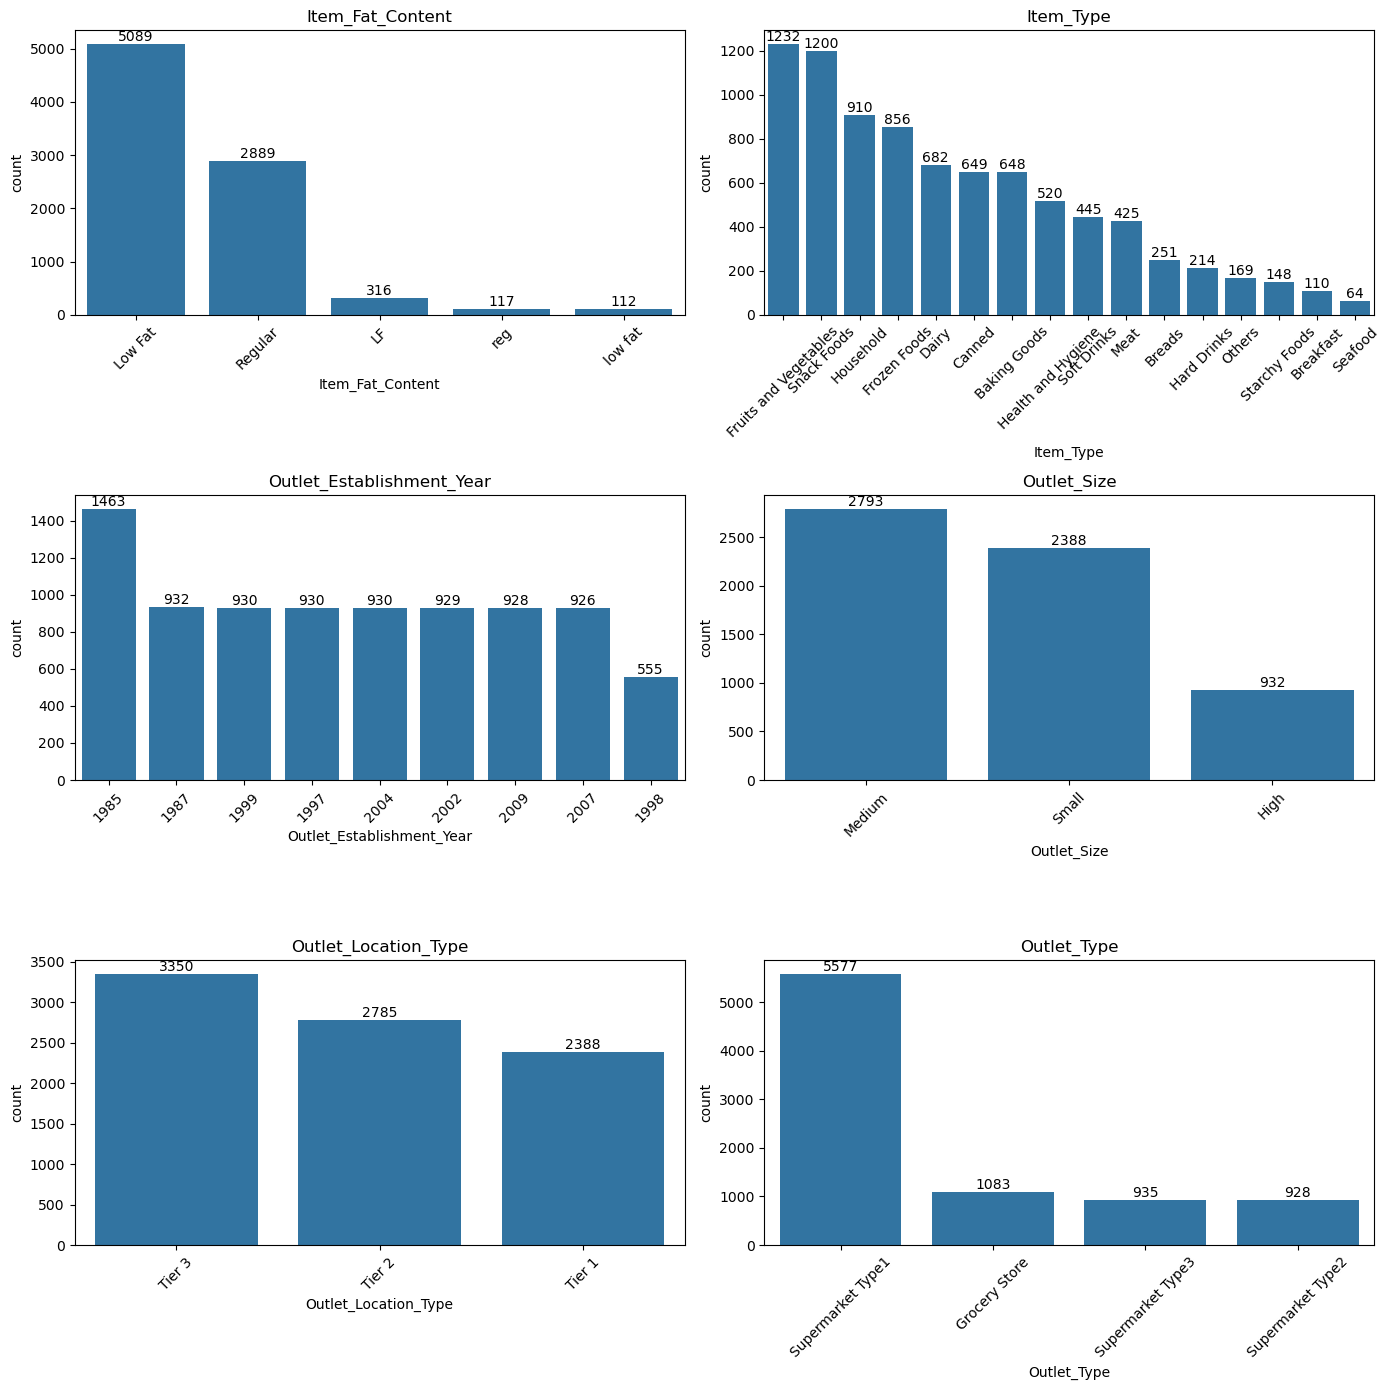

In [8]:
cat_cols = ['Item_Fat_Content', 'Item_Type', 'Outlet_Establishment_Year', 
                    'Outlet_Size', 'Outlet_Location_Type','Outlet_Type']
plt.figure(figsize=(14, 14))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(3, 2, i)
    ax = sns.countplot(data=df_train, x=col, order=df_train[col].value_counts().index)
    ax.bar_label(ax.containers[0])
    plt.title(f'{col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
plt.show()

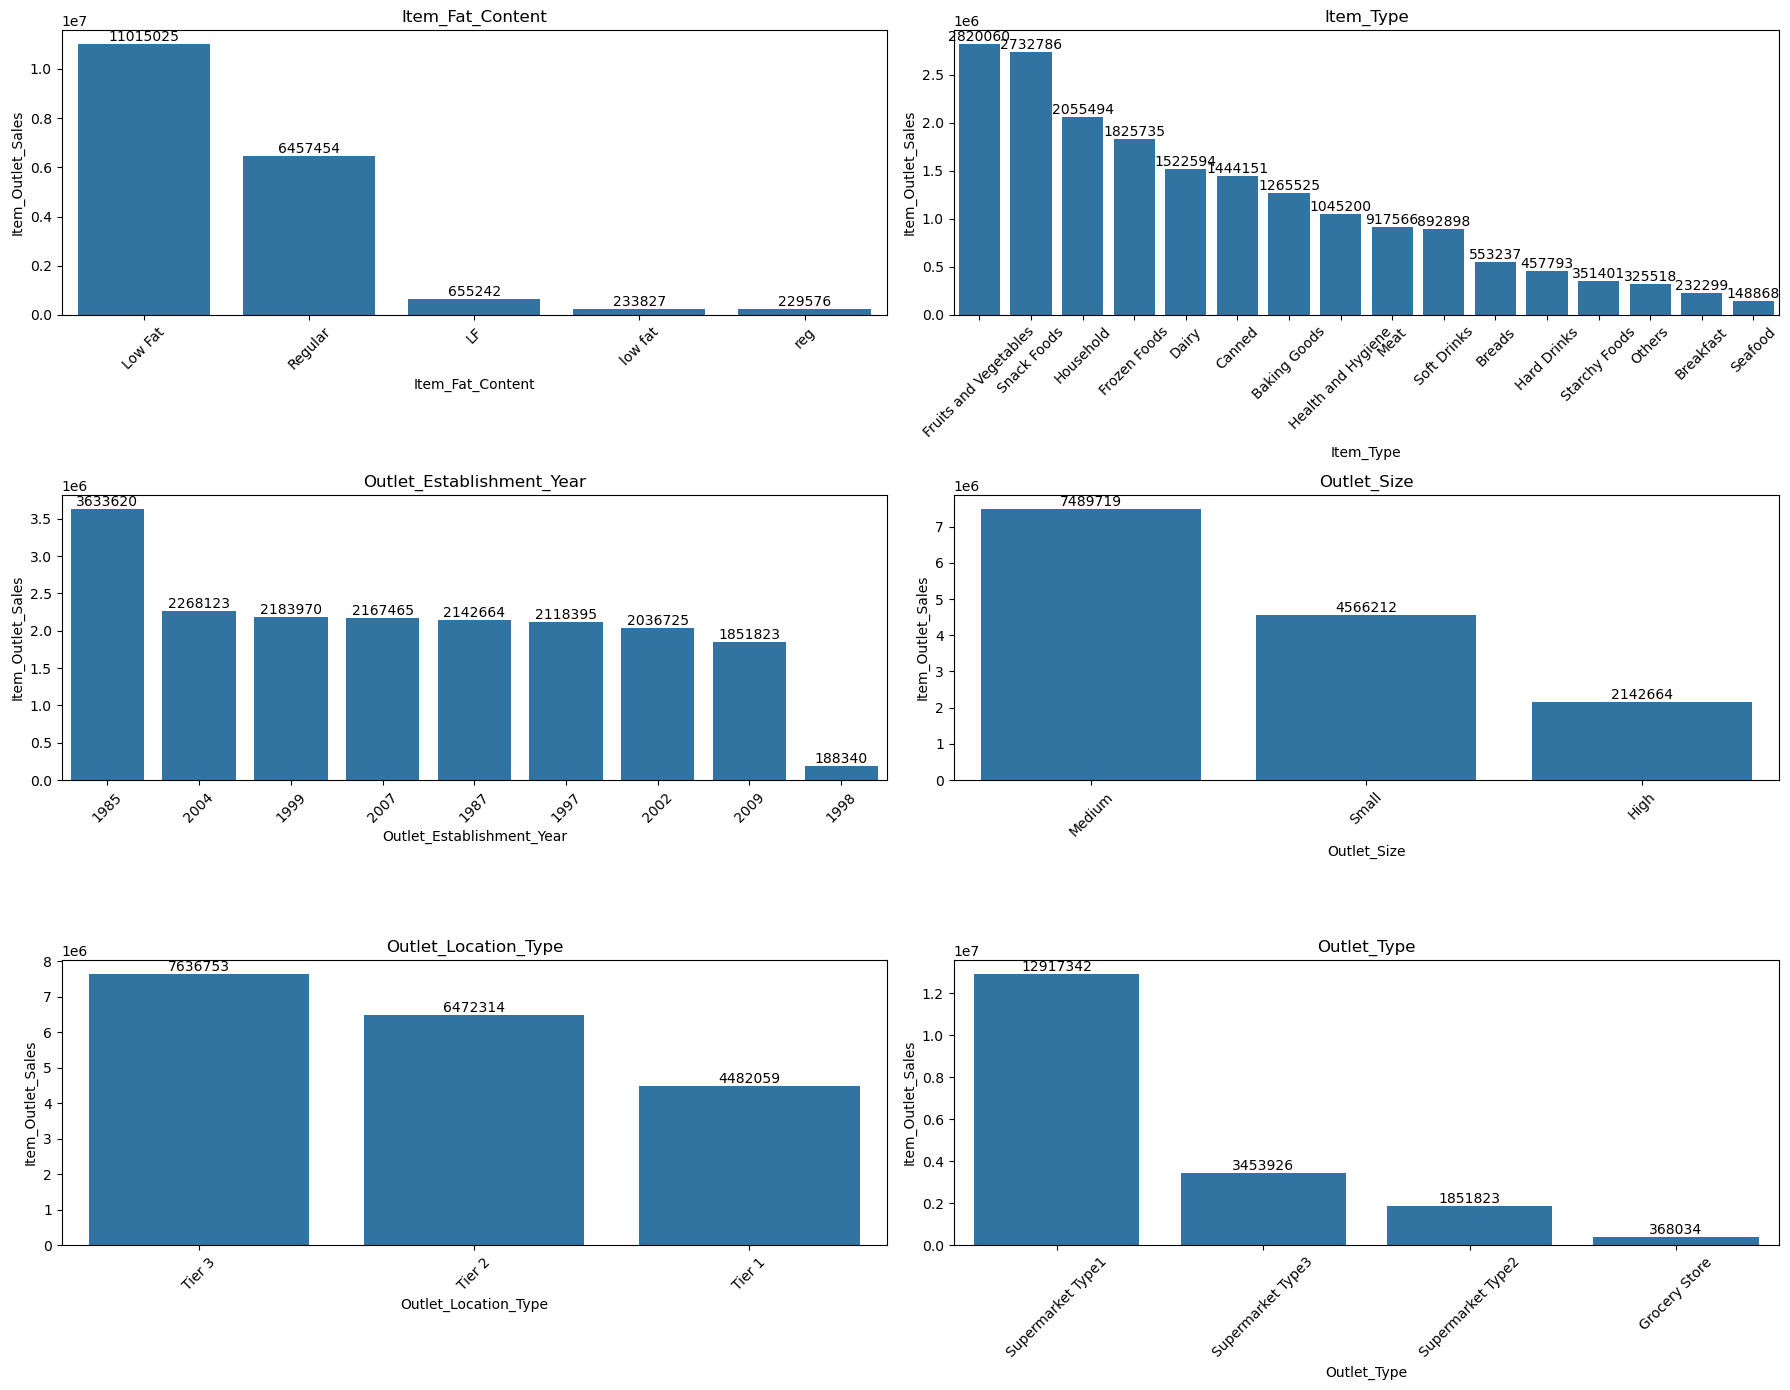

In [9]:
#Sum of Item_Outlet_Sales by Categorical columns
plt.figure(figsize=(18, 14))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(3, 2, i)
    foo_df = df_train.groupby(col)['Item_Outlet_Sales'].sum().reset_index()
    ax = sns.barplot(data=foo_df, x=col, y='Item_Outlet_Sales', 
                      order=foo_df.sort_values('Item_Outlet_Sales', ascending=False)[col])
    for container in ax.containers:
        ax.bar_label(container, fmt='%.0f')
    plt.title(f'{col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
plt.show()

#### Few observations:
- Item_Fat_Content needs to be cleaned
- Majority of the Sales are from Supermarket Type1 in Outlet_Type 
- There are many categories in Item_Type, lets see if we can reduce the categories and check how model performs
- Missing values to be imputed for Item_Fat_Content and Outlet_Size

#### Data cleaning in Item_Fat_Content

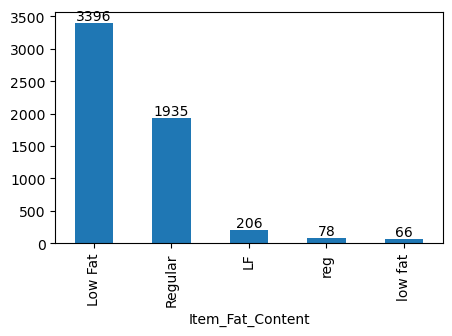

In [10]:
ax = df_test['Item_Fat_Content'].value_counts().plot(kind='bar', figsize=(5, 3), )
ax.bar_label(ax.containers[0])
plt.show()

In [11]:
#Data cleaning
df_train['Item_Fat_Content'] = df_train['Item_Fat_Content'].replace({'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg': 'Regular'})
df_test['Item_Fat_Content'] = df_test['Item_Fat_Content'].replace({'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg': 'Regular'})

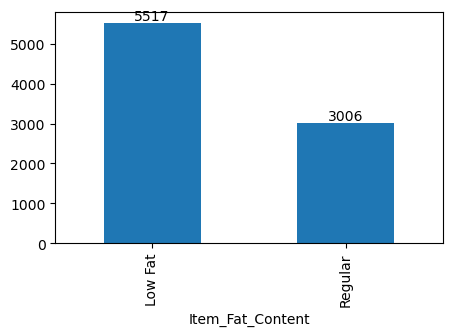

In [12]:
ax = df_train['Item_Fat_Content'].value_counts().plot(kind='bar', figsize=(5, 3), )
ax.bar_label(ax.containers[0])
plt.show()

##### Trying various methods to fill missing values in Item_Weight

In [13]:
df_test.isnull().sum()

Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [14]:
#Combining both train and test datasets to impute missing values
total_df = pd.concat([df_train, df_test], ignore_index=True)

In [15]:
imp_df = total_df.drop(['Item_Identifier', 'Outlet_Identifier'], axis=1)

rmse_scores = {}


def col_median(df):
    df = df.copy()
    df['Item_Weight'].fillna(df['Item_Weight'].median(), inplace=True)
    return df

def other_cols_median(df, group_col):
    df = df.copy()
    group_mean = df.groupby(group_col)['Item_Weight'].transform('median')
    df.loc[df['Item_Weight'].isnull(), 'Item_Weight'] = group_mean[df['Item_Weight'].isnull()]
    return df

def impute_knn(df):
    df = df.copy()
    imputer = KNNImputer(n_neighbors=5)
    df[['Item_Weight']] = imputer.fit_transform(df[['Item_Weight']])
    return df

def impute_mice(df):
    df = df.copy()
    imputer = IterativeImputer(random_state=0)
    df[['Item_Weight']] = imputer.fit_transform(df[['Item_Weight']])
    return df

imputation_methods = {
    'median': col_median,
    'Item_Type': lambda df: other_cols_median(df, 'Item_Type'),
    'Item_Fat_Content': lambda df: other_cols_median(df, 'Item_Fat_Content'),
    'Item_Type__Item_Fat_Content': lambda df: other_cols_median(df, ['Item_Type', 'Item_Fat_Content']),
    'knn': impute_knn,
    'mice': impute_mice,
}

for i, j in imputation_methods.items():
    imputed_df = j(imp_df)
    
    imputed_df = pd.get_dummies(imputed_df, drop_first=True)
    
    train_data = imputed_df[:df_train.shape[0]]
    X = train_data.drop('Item_Outlet_Sales', axis=1)
    y = train_data['Item_Outlet_Sales']
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    rmse_scores[i] = rmse

min_rmse = min(rmse_scores, key=rmse_scores.get)
print("RMSE scores for each imputation method:")
for method, score in rmse_scores.items():
    print(f"{method}: {score:.1f}")

C:\Users\INYOS1\AppData\Local\Temp\ipykernel_45504\1367987241.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Item_Weight'].fillna(df['Item_Weight'].median(), inplace=True)


RMSE scores for each imputation method:
median: 1035.4
Item_Type: 1034.7
Item_Fat_Content: 1035.4
Item_Type__Item_Fat_Content: 1034.8
knn: 1035.5
mice: 1035.5


Using simple Gradient Boost regressor model, we can see that median of Item_Weight based on Item_Type and Item_Fat_Content gives low RMSE score. I will go with the combination

In [16]:
total_df['Item_Weight'].isnull().sum()

2439

In [17]:
means = total_df.groupby(['Item_Type','Item_Fat_Content'])['Item_Weight'].transform('median')
total_df.loc[total_df['Item_Weight'].isnull(), 'Item_Weight'] = means[total_df['Item_Weight'].isnull()]

In [18]:
# total_df['Item_Weight'].fillna(total_df.groupby(['Item_Type','Item_Fat_Content'])['Item_Weight'].transform('median'), inplace=True)

In [19]:
total_df['Item_Weight'].isnull().sum()

0

Filling missing values in 'Outlet_Size' based on other Outlet related cols in total_df

In [20]:
total_df['Outlet_Size'].isnull().sum()

4016

In [21]:
total_df['Conc1'] = (total_df['Outlet_Establishment_Year'].astype(str) + '_' +
    total_df['Outlet_Location_Type'].astype(str) + '_' + total_df['Outlet_Type'].astype(str))

total_df['Conc2'] = (total_df['Outlet_Location_Type'].astype(str) + '_' +total_df['Outlet_Type'].astype(str))

#Using combn of 3 cols
combo1_mode = total_df.groupby('Conc1')['Outlet_Size'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA)
total_df['Outlet_Size'] = total_df['Outlet_Size'].fillna(total_df['Conc1'].map(combo1_mode))

#Using combn of 2 cols
combo2_mode = total_df.groupby('Conc2')['Outlet_Size'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA)
total_df['Outlet_Size'] = total_df['Outlet_Size'].fillna(total_df['Conc2'].map(combo2_mode))

#Using Outlet_Type col
type_mode = total_df.groupby('Outlet_Type')['Outlet_Size'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA)
total_df['Outlet_Size'] = total_df['Outlet_Size'].fillna(total_df['Outlet_Type'].map(type_mode))

#For remaining, use Outlet_Size mode
overall_mode = total_df['Outlet_Size'].mode().iloc[0]
total_df['Outlet_Size'] = total_df['Outlet_Size'].fillna(overall_mode)

total_df.drop(columns=['Conc1', 'Conc2'], inplace=True)

In [22]:
total_df.isnull().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                     0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
dtype: int64

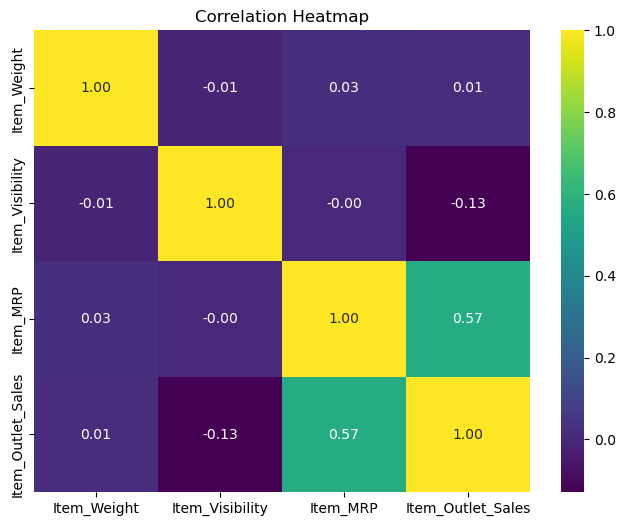

In [23]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_train[['Item_Weight','Item_Visibility','Item_MRP','Item_Outlet_Sales']].corr(), annot=True, cmap='viridis', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Item_Weight has low correlation w.r.t DV, models can be tried with and without this variable

#### Encoding categorical variables

Trying to identify which encoding method is best for the data

In [26]:
rmse_scores = {}
X = df_train.drop(['Item_Identifier','Item_Outlet_Sales','Outlet_Identifier'], axis=1)
y = df_train['Item_Outlet_Sales']
enc = ['onehot', 'label']

for i in enc:
    X_enc = X.copy()
    if i == 'onehot':
        X_enc = pd.get_dummies(X_enc, drop_first=True)
    else:
        for col in ['Item_Type','Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']:
            le = LabelEncoder()
            X_enc[col] = le.fit_transform(X_enc[col]).astype(str)

    X_train, X_val, y_train, y_val = train_test_split(X_enc, y, test_size=0.2, random_state=42)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    rmse_scores[i] = rmse

min_rmse = min(rmse_scores, key=rmse_scores.get)
for method, score in rmse_scores.items():
    print(f"{method}: {score:.1f}")
print(f"Best encoding method: {min_rmse}")


onehot: 1097.4
label: 1090.7
Best encoding method: label


In [27]:
le = LabelEncoder()
for col in ['Item_Type','Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']:
    total_df[col] = le.fit_transform(total_df[col].astype(str))

In [28]:
total_df.head(10)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,0,0.016047,4,249.8092,OUT049,1999,1,0,1,3735.1380
1,DRC01,5.920,1,0.019278,14,48.2692,OUT018,2009,1,2,2,443.4228
2,FDN15,17.500,0,0.016760,10,141.6180,OUT049,1999,1,0,1,2097.2700
3,FDX07,19.200,1,0.000000,6,182.0950,OUT010,1998,2,2,0,732.3800
4,NCD19,8.930,0,0.000000,9,53.8614,OUT013,1987,0,2,1,994.7052
5,FDP36,10.395,1,0.000000,0,51.4008,OUT018,2009,1,2,2,556.6088
6,FDO10,13.650,1,0.012741,13,57.6588,OUT013,1987,0,2,1,343.5528
7,FDP10,14.100,0,0.127470,13,107.7622,OUT027,1985,1,2,3,4022.7636
8,FDH17,16.200,1,0.016687,5,96.9726,OUT045,2002,2,1,1,1076.5986
9,FDU28,19.200,1,0.094450,5,187.8214,OUT017,2007,2,1,1,4710.5350


In [29]:
total_df.drop(['Item_Identifier', 'Outlet_Identifier'], axis=1, inplace=True)

train_data = total_df[:df_train.shape[0]]
test_data = total_df[df_train.shape[0]:]
X = train_data.drop('Item_Outlet_Sales', axis=1)
y = train_data['Item_Outlet_Sales']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    results[name] = rmse

ann = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)
])
ann.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
ann.fit(X_train_scaled, y_train, epochs=50, batch_size=64, verbose=0)
ann_preds = ann.predict(X_val_scaled).flatten()
ann_rmse = np.sqrt(mean_squared_error(y_val, ann_preds))
results["ANN"] = ann_rmse

best_model_name = min(results, key=results.get)
print("Model RMSEs:")
for name, rmse in results.items():
    print(f"{name}: {rmse:.2f}")
print(f"\nBest model: {best_model_name}")

c:\Users\INYOS1\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Model RMSEs:
Linear Regression: 1142.97
Random Forest: 1087.97
AdaBoost: 1213.31
Gradient Boosting: 1035.07
XGBoost: 1128.14
ANN: 1032.04

Best model: ANN


Considering ANN since it is giving lowest rmse, below code performs hyper parameter finetuning

*Not running the below cell, since it takes > 1hr*

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

params = {
    'learning_rate': [0.001, 0.01],
    'neurons1': [64, 128],
    'neurons2': [32, 64],
    'activation': ['relu', 'tanh'],
    'batch_size': [32, 64],
    'epochs': [50, 100]
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = []

for lr in params['learning_rate']:
    for n1 in params['neurons1']:
        for n2 in params['neurons2']:
            for act in params['activation']:
                for bs in params['batch_size']:
                    for ep in params['epochs']:
                        rmses = []
                        for train_idx, val_idx in kf.split(X_scaled):
                            X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
                            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

                            model = Sequential([
                                Dense(n1, activation=act, input_shape=(X_scaled.shape[1],)),
                                Dense(n2, activation=act),
                                Dense(1)
                            ])
                            model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')
                            model.fit(X_train, y_train, epochs=ep, batch_size=bs, verbose=0)

                            preds = model.predict(X_val).flatten()
                            rmse = np.sqrt(mean_squared_error(y_val, preds))
                            rmses.append(rmse)

                        avg_rmse = np.mean(rmses)
                        results.append({
                            'learning_rate': lr,
                            'neurons1': n1,
                            'neurons2': n2,
                            'activation': act,
                            'batch_size': bs,
                            'epochs': ep,
                            'avg_rmse': avg_rmse
                        })


best_config = min(results, key=lambda x: x['avg_rmse'])
print("Best Hyperparameters:", best_config)

Based on the above code, best parameters obtained are:

In [27]:
'''
{'learning_rate': 0.001,
 'neurons1': 128,
 'neurons2': 32,
 'activation': 'relu',
 'batch_size': 32,
 'epochs': 100,
 'avg_rmse': 1081.3238498440846}
 '''

"\n{'learning_rate': 0.001,\n 'neurons1': 128,\n 'neurons2': 32,\n 'activation': 'relu',\n 'batch_size': 32,\n 'epochs': 100,\n 'avg_rmse': 1081.3238498440846}\n "

Retraining ANN model with above hyper parameters on complete train set

In [30]:
test_ids = df_test[['Item_Identifier', 'Outlet_Identifier']].copy()
X_test_final = test_data.drop('Item_Outlet_Sales', axis=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test_final)


ann = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])
ann.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
ann.fit(X_train_scaled, y, epochs=100, batch_size=32, verbose=0)
final_preds = ann.predict(X_test_scaled).flatten()

c:\Users\INYOS1\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step


In [ ]:
test = test_ids.copy()
test['Item_Outlet_Sales'] = final_preds
test.to_csv("submission5.2.csv", index=False)